In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
reviews = pd.read_csv("IMDB Dataset.csv")
reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
reviews['sentiment'] = np.where(reviews['sentiment'] == 'positive', 1, 0)

In [4]:
sentences = reviews['review'].to_numpy()
labels = reviews['sentiment'].to_numpy()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.2)
print("Training Data Input Shape: ", X_train.shape)
print("Training Data Output Shape: ", y_train.shape)
print("Testing Data Input Shape: ", X_test.shape)
print("Testing Data Output Shape: ", y_test.shape)

Training Data Input Shape:  (40000,)
Training Data Output Shape:  (40000,)
Testing Data Input Shape:  (10000,)
Testing Data Output Shape:  (10000,)


In [6]:
vocab_size = 10000
ovv_tok = "<OOV>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token= ovv_tok)

In [7]:
tokenizer.fit_on_texts(X_train)
print("N Documents:", tokenizer.document_count)
print("N Words:", tokenizer.num_words)

N Documents: 40000
N Words: 10000


In [8]:
tokenizer.word_counts

OrderedDict([('i', 123895),
             ('watched', 3587),
             ('this', 120842),
             ('movie', 69725),
             ('and', 259741),
             ('the', 534108),
             ('original', 5082),
             ('carlitos', 6),
             ('way', 12466),
             ('back', 7705),
             ('to', 214552),
             ('difference', 584),
             ('between', 5287),
             ('two', 10830),
             ('is', 169248),
             ('disgusting', 369),
             ('now', 7438),
             ('know', 10049),
             ('that', 109577),
             ('people', 14203),
             ('are', 46713),
             ('going', 6500),
             ('say', 8583),
             ('prequel', 100),
             ('was', 76644),
             ('made', 12913),
             ('on', 54482),
             ('a', 258736),
             ('small', 2564),
             ('budget', 3057),
             ('but', 67038),
             ('never', 10291),
             ('had', 17622),
      

In [9]:
train_sequences = tokenizer.texts_to_sequences(X_train)
print(train_sequences[0])

[11, 291, 12, 18, 3, 2, 210, 1, 96, 143, 6, 143, 2, 1485, 201, 2, 106, 7, 2191, 147, 11, 118, 13, 83, 24, 167, 6, 132, 13, 2, 5974, 14, 91, 21, 4, 394, 337, 19, 13, 113, 68, 233, 6, 78, 16, 4, 75, 229, 147, 268, 45, 40, 70, 19, 11, 213, 191, 13, 4, 5974, 14, 91, 6, 140, 272, 54, 2, 80, 18, 1217, 1383, 103, 3, 268, 5575, 9, 4, 227, 42, 115, 13, 74, 155, 118, 2225, 6, 656, 7, 40, 4, 18, 13, 46, 1, 388, 47, 142, 26, 77, 31, 223, 4, 172, 103, 37, 2, 210, 18, 2, 273, 162, 55, 282, 9, 4691, 6, 2, 210, 9, 2, 128, 5, 12, 18, 29, 1, 16, 25, 1106, 489, 19, 88, 2, 615, 78, 74, 76, 86, 561, 43, 5, 1158, 9, 2, 370, 18, 3, 25, 257, 216, 58, 2, 168, 257, 13, 29, 2171, 42, 15, 25, 62, 111, 9, 2, 210, 11, 59, 132, 2, 18, 7, 2633, 428, 9, 95, 546, 16, 4, 172, 534, 1758, 19, 10, 1, 52, 1464, 54, 6, 45, 190, 617, 90, 4118, 4612, 31, 310, 1103, 6, 64, 12, 104, 2, 210, 28, 51, 56, 44, 23, 63, 362, 4, 576]


In [10]:
sequence_length = 200
train_padded = pad_sequences(train_sequences, maxlen= sequence_length, padding= 'post', truncating= 'post')

In [11]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen= sequence_length, padding= 'post', truncating= 'post')

In [12]:
model = Sequential()

In [13]:
embedding_dim = 16
model.add(Embedding(vocab_size, embedding_dim, input_length= sequence_length))

In [14]:
lstm_out = 32
model.add(Bidirectional(LSTM(lstm_out)))

In [15]:
model.add(Dense(10, activation= 'relu'))
model.add(Dense(1, activation= 'sigmoid'))

In [16]:
model.compile(loss= 'binary_crossentropy')

In [17]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 173,205
Trainable params: 173,205
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
#Stop the training when fails to lower the validation to avoid overfitting
checkpoint_filepath= os.getcwd()
#Monitor the loss after each epoch & save the best model
model_checkpoint_callback= ModelCheckpoint(filepath= checkpoint_filepath, save_weights_only= False, monitor= 'val_loss', mode= 'min', save_best_only= True)
callbacks= [EarlyStopping(patience= 2), model_checkpoint_callback]

In [19]:
history= model.fit(train_padded, y_train, epochs= 10, validation_data= (test_padded, y_test), callbacks= callbacks)

Epoch 1/10
1250/1250 [==============================] - ETA: 0s - loss: 0.4067

INFO:tensorflow:Assets written to: C:\Users\amin\Desktop\Nlp imp\assets


INFO:tensorflow:Assets written to: C:\Users\amin\Desktop\Nlp imp\assets


1250/1250 [==============================] - 244s 191ms/step - loss: 0.4067 - val_loss: 0.3361
Epoch 2/10
1250/1250 [==============================] - ETA: 0s - loss: 0.2930

INFO:tensorflow:Assets written to: C:\Users\amin\Desktop\Nlp imp\assets


INFO:tensorflow:Assets written to: C:\Users\amin\Desktop\Nlp imp\assets


1250/1250 [==============================] - 224s 179ms/step - loss: 0.2930 - val_loss: 0.3089
Epoch 3/10
1250/1250 [==============================] - 190s 152ms/step - loss: 0.2627 - val_loss: 0.3110
Epoch 4/10
1250/1250 [==============================] - ETA: 0s - loss: 0.2492

INFO:tensorflow:Assets written to: C:\Users\amin\Desktop\Nlp imp\assets


INFO:tensorflow:Assets written to: C:\Users\amin\Desktop\Nlp imp\assets


1250/1250 [==============================] - 233s 186ms/step - loss: 0.2492 - val_loss: 0.2944
Epoch 5/10
1250/1250 [==============================] - ETA: 0s - loss: 0.2396

INFO:tensorflow:Assets written to: C:\Users\amin\Desktop\Nlp imp\assets


INFO:tensorflow:Assets written to: C:\Users\amin\Desktop\Nlp imp\assets


1250/1250 [==============================] - 235s 188ms/step - loss: 0.2396 - val_loss: 0.2890
Epoch 6/10
1250/1250 [==============================] - 205s 164ms/step - loss: 0.2305 - val_loss: 0.3017
Epoch 7/10
1250/1250 [==============================] - 199s 159ms/step - loss: 0.2222 - val_loss: 0.3186


In [20]:
metrics_df= pd.DataFrame(history.history)
print(metrics_df)

       loss  val_loss
0  0.406683  0.336082
1  0.292968  0.308873
2  0.262729  0.311003
3  0.249191  0.294381
4  0.239561  0.288989
5  0.230506  0.301667
6  0.222210  0.318574


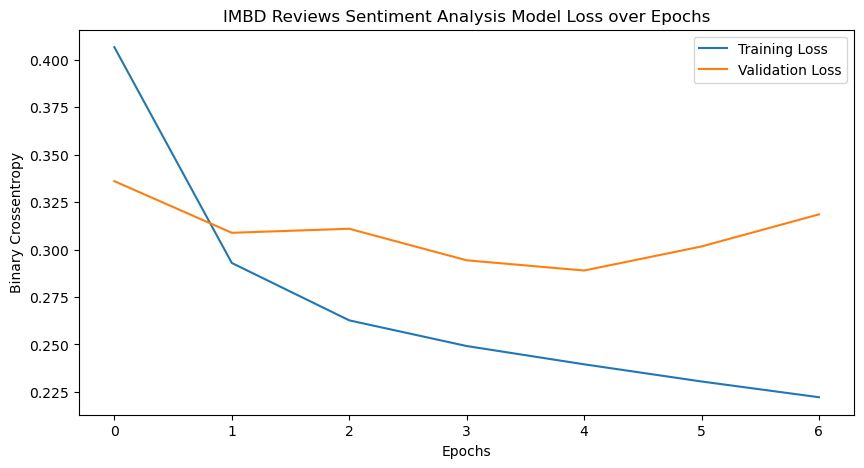

In [22]:
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.loss)
plt.plot(metrics_df.index, metrics_df.val_loss)
plt.title('IMBD Reviews Sentiment Analysis Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [ ]:
s = ['Although some parts were interesting, I think that it was overally a toatal waste of time. Many parts were really confusing and it lacked any kind of orininality',
    'The acting was great, song was wonderful and the story was enjoyful to follow. I really loved this movie.']
s_tok = tokenizer.texts_to_sequences(s)
s_pad = pad_sequences(s_tok, maxlen=sequence_length, padding='post', truncating='post')

In [31]:
model.predict(s_pad)

1/1 [==============================] - 0s 91ms/step


array([[0.03294995],
       [0.960866  ]], dtype=float32)

In [32]:
pred = model.predict(test_padded)
pred = np.where(pred>0.5, 1, 0)

313/313 [==============================] - 18s 56ms/step


In [35]:
sum = 0
N = 0
for i in range(len(pred)):
    if pred[i] == y_test[i]:
        sum+= 1
    N+= 1
print(sum/)

0.878
